## Project Name: Prediction of PM2.5 level at an AQMD station: using nearby stations’ data

### Background
- This project is the final project of Machine Learning course (CSCA 5622) at University of Colorado Boulder.
- Team members are Nitish Venkatesh Septankulam Ramakrishnan, Meghana Vasanth Shettigar, and Jooseok Lee.
- Simplified from the original one.

### Overview
- In this project, we aim to develop a machine learning model that can predict the level of PM2.5 of stations that have no PM2.5 level monitoring capability. 
- To achieve that, we build a machine learning model that predicts the PM2.5 level of a target station using PM2.5 level data of nearby stations. 
- We also utilize other commonly monitored air pollution data, such as level of NO2 and CO, and basic meteorological data, such as wind direction and speed, to increase the performance of the model. 
- The development direction is based on the assumption that the air quality of one station has a spatiotemporal correlation to the air quality of nearby stations.


### Apporach
- In this project, we aim to develop a machine learning model that can predict the level of PM2.5 of stations that have no PM2.5 level monitoring capability. 
- In order to do this, we build a CNN-based machine learning model that take nearby stations’ data as input and predict the target station’s PM2.5 level.  

<div align="center">
    <img src="img/Approach.jpg" alt="Approach" width="500">
</div>

### Target and Nearby Stations
- We select Mira Loma station as our target station and five other stations (i.e. Upland, LakeElsinore, Temecula, Banning, and Central San Bernardino stations) as nearby stations. 
- The selection criteria is the number of missing values in PM2.5 and proximity).

<div align="center">
    <img src="img/Stations.jpg" alt="Stations" width="500">
</div>

### Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
from scipy import signal
import statsmodels.api as sm
import datetime

In [3]:
# Reading files
XTrain_path = r'data/XTrain.csv'
yTrain_path = r'data/yTrain.csv'
XTest_path = r'data/XTest.csv'
yTest_path = r'data/yTest.csv'

XTrain = pd.read_csv(XTrain_path, on_bad_lines='skip')
yTrain = pd.read_csv(yTrain_path, on_bad_lines='skip')

XTest = pd.read_csv(XTest_path, on_bad_lines='skip')
yTest = pd.read_csv(yTest_path, on_bad_lines='skip')

print('Shape of XTrain: ' + str(XTrain.shape) + ' -> XTrain dataset for fitting the main models')
print('Shape of yTrain: ' + str(yTrain.shape) + ' -> yTrain dataset for fitting the main/base1/base2 models')

print('Shape of XTest: ' + str(XTest.shape) + ' -> XTest dataset for testing the main models')
print('Shape of yTest: ' + str(yTest.shape) + ' -> yTest dataset for testing the moain/base1/base2 models')

Shape of XTrain: (34890, 12) -> XTrain dataset for fitting the main models
Shape of yTrain: (34723, 2) -> yTrain dataset for fitting the main/base1/base2 models
Shape of XTest: (8730, 12) -> XTest dataset for testing the main models
Shape of yTest: (8563, 2) -> yTest dataset for testing the moain/base1/base2 models


In [4]:
# Clipping PM25 data
# Small subset of PM25 value is much higher than average
# Clip PM25 values to 0~100 (Over 100 is very poor according to the EPA)
columns=['Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']
columns2 = ['PM25', 'Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']

XTrain[columns] = np.clip(XTrain[columns], a_min=0, a_max=100)
XTest[columns] = np.clip(XTest[columns], a_min=0, a_max=100)

yTrain['PM25'] = np.clip(yTrain['PM25'], a_min=0, a_max=100)
yTest['PM25'] = np.clip(yTest['PM25'], a_min=0, a_max=100)

In [5]:
# Standardization
# Standardize the Training data for each column
from sklearn.preprocessing import StandardScaler

ori_col = [column for column in XTrain.columns if column!='Date Time']

scaler_train = StandardScaler()

scaler_train.fit(XTrain[ori_col])
XTrain_std = scaler_train.transform(XTrain[ori_col])
XTest_std = scaler_train.transform(XTest[ori_col])

### Data Preprocessing
- We aim to build machine learning models that predict the PM2.5 level after six steps (i.e. after six hours) using the previous seven days’ data (i.e. 168 hours of past data). 
- To achieve this, we add an additional preprocessing step to change the shape of data into the desired one.

<div align="center">
    <img src="img/Preprocessing.jpg" alt="Preprocessing" width="500">
</div>

In [6]:
# Preparing for time-series train/test data
# Rolling the data 
# For example, XTrain[:167] is matched with yTrain[0], XTrain[1:168] is matched with yTrain[1] and so on
window = 168

def rolling_data(X, y, window):
    X_ts = []
    
    for i in range(len(y)):
        start = i
        end = i + window
        X_ts.append(X[start:end, :])
        
    return X_ts

XTrain_ts = np.array(rolling_data(XTrain_std, yTrain, window))
XTest_ts = np.array(rolling_data(XTest_std, yTest, window))

print('Shape of XTrain: ' + str(XTrain_ts.shape))
print('Shape of XTest: ' + str(XTest_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTest: (8563, 168, 11)


In [7]:
# Reshaping the input data to make it fit for CNN models
# Reshaping a sample data from (168, 11) to (24, 7, 11)
# Since there is a strong relationship every 24 hours, we decided to reshape the data to (24, 7, 11)
# Input data shape: (no of samples, hours, day, no of features)

XTrain_ts = XTrain_ts.reshape((XTrain_ts.shape))
XTest_ts = XTest_ts.reshape((XTest_ts.shape))

print('Shape of XTrain: ' + str(XTrain_ts.shape))
print('Shape of XTest: ' + str(XTest_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTest: (8563, 168, 11)


### Building CNN Model
- This model has one 1D convolutional layer. 
- It has a kernel size of (24,) and 12 channels. 
- The batch normalization is done after the convolutional layer followed by RELU activation. 
- Then, the AveragePooling1D layer and Flatten layer are applied to the model. 
- Finally, two Dense layers, Dense(16) and Dense(8) respectively, are applied to produce the final output.  
- Adam optimizer with learning rate  0.001 and MSE loss function are used to train the model. 
- The CNN structure we used in this project is selected after trying several different options, such as increasing the number of 1D convolutional layers, changing the size of kernel and channels, or changing the learning rate. 


<div align="center">
    <img src="img/CNN.jpg" alt="Preprocessing" width="500">
</div>

In [11]:
from tensorflow import keras

# Build a CNN model
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=12, kernel_size=24, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv1_pool = keras.layers.AveragePooling1D(pool_size=2)(conv1)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=24, padding="same")(conv1_pool)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv2_pool = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    conv3 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv2_pool)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    conv3_max = keras.layers.MaxPool1D(pool_size=3)(conv3)

    conv4 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv3_max)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    flatten = keras.layers.Flatten()(conv1_pool)

    dense1 = keras.layers.Dense(16)(flatten)
    dense2 = keras.layers.Dense(8)(dense1)


    output_layer = keras.layers.Dense(1)(dense2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [25]:
# Main model
model_main = make_model(input_shape=XTrain_ts.shape[1:])

epochs = 5
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model_checkpoint/best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_main.compile(
    optimizer="adam",
    loss="mse",
    metrics=['mae'],
    run_eagerly=True
)
history = model_main.fit(
    np.asarray(XTrain_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - loss: 137.1945 - mae: 8.3440 - val_loss: 98.8598 - val_mae: 6.8898 - learning_rate: 0.0010
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 59.4622 - mae: 5.1579 - val_loss: 87.1217 - val_mae: 6.4557 - learning_rate: 0.0010
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 52.5772 - mae: 4.8574 - val_loss: 86.9149 - val_mae: 6.5043 - learning_rate: 0.0010
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 49.8293 - mae: 4.7581 - val_loss: 78.5991 - val_mae: 6.1584 - learning_rate: 0.0010
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 50.5704 - mae: 4.6551 - val_loss: 82.4624 - val_mae: 6.2989 - learning_rate: 0.0010


In [16]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_hat = model_main.predict(XTest_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
R2_score: 0.3835519658812826
MSE: 71.05293891750672
MAE: 5.5999510374634625


Text(0, 0.5, 'Prediction')

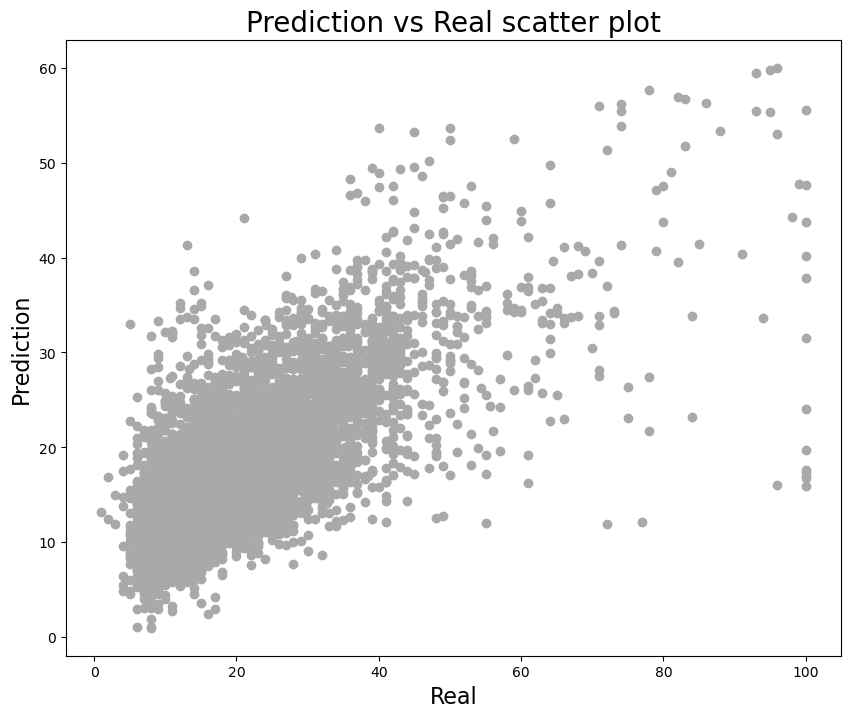

In [17]:
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(yTest['PM25'], y_hat, c='darkgrey')
plt.title('Prediction vs Real scatter plot', fontsize=20)
plt.xlabel('Real', fontsize=16)
plt.ylabel('Prediction', fontsize=16)

<Axes: title={'center': 'Average error according to PM2.5 Level'}, xlabel='Real PM2.5 Level', ylabel='Absoulte Error'>

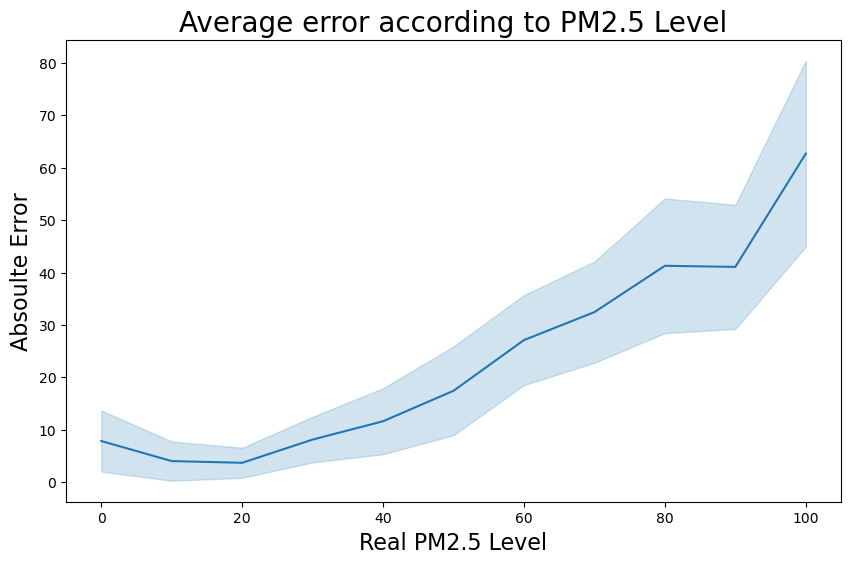

In [24]:
import seaborn as sns

df = pd.DataFrame(yTest['PM25'])
df['yhat'] = pd.DataFrame(y_hat)
df['diff'] = abs(df['PM25']-df['yhat'])
df['rnd'] = np.round(df['PM25'], -1)

df_grp = df.groupby('rnd').mean()['diff']
x = df['rnd']
y = df['diff']

plt.figure(figsize=(10, 6))
plt.xlabel('Real PM2.5 Level', fontsize=16)
plt.ylabel('Absoulte Error', fontsize=16)
plt.title('Average error according to PM2.5 Level', fontsize=20)
sns.lineplot(
    data=df, 
    x='rnd', 
    y='diff', 
    errorbar='sd',  # or ci='95' for 95% confidence interval    
)